# Logical shadow tomography: $[[5, 1, 3]]$ code example

## Setup

In [1]:
from joblib import Parallel, delayed

import matplotlib.pyplot as plt
import numpy as np
from numba import njit

from base.stabilizer import random_clifford_state, stabilizer_state, stoc_depolarize_map
from base.utils import stabilizer_projection_full

In [2]:
plt.rcParams.update({"font.family": "serif", "font.size": 16})

## Experiment

In [3]:
"""Set experimental parameters."""
num_trajectories: int = 100_000  # Number of trajectories to sample from.

pmin: float = 0.0  # Minimum depolarizing noise rate.
pmax: float = 0.5  # Maximum depolarizing noise rate.
step: float = 0.05  # Step for depolarizing noise rates. Values are `np.arange(pmin, pmax + step, step)`.

njobs: int = 2  # Number of parallel workers to use when sampling trajectories.

In [7]:
pvalues = np.arange(pmin, pmax + step, step)
N: int = 5

In [8]:
def sample_trajectory(p: float):
    # Initial stabilizer state. TODO: This could be sped up by computing once 
    #  then making a copy here.
    state = stabilizer_state("ZZZZZ", "XZZXI", "IXZZX", "XIXZZ", "ZXIXZ")
    gs0 = state.gs.copy()
    ps0 = state.ps.copy()

    # Apply single-qubit depolarizing noise.
    state = stoc_depolarize_map(state, p)

    # Do shadow tomography.
    obs = random_clifford_state(N)
    state.measure(obs)

    gs, ps, _, tmp_PsigmaP = stabilizer_projection_full(
        state.gs, state.ps, gs0[: N - 1].copy(), ps0[: N - 1].copy(), 0
    )
    _, _, _, tmp = stabilizer_projection_full(gs, ps, gs0[:N], ps0[:N], 0)
    
    return tmp_PsigmaP * tmp, tmp_PsigmaP

In [9]:
"""Run the experiment."""
fid_list = np.ones_like(pvalues)

for (i, p) in enumerate(pvalues):
    # Status update.
    print(f"Status: On noise rate p = {p:.3f}", end="\r")

    values = Parallel(n_jobs=njobs)(
        delayed(sample_trajectory)(p) for _ in range(num_trajectories)
    )
    num, denom = np.sum(values, axis=0)

    # Compute final fidelity.
    fid = ((2 ** N + 1) * (num / num_trajectories) - 1) / ((denom / num_trajectories) * (2 ** N + 1) - 2)
    fid_list[i] = fid

In [10]:
def FL(p):
    N = (8 * p ** 2 - 9 * p + 3) * (2 * p - 3) ** 3
    D = 240 * p ** 4 - 720 * p ** 3 + 810 * p ** 2 - 405 * p + 81
    return -N / D

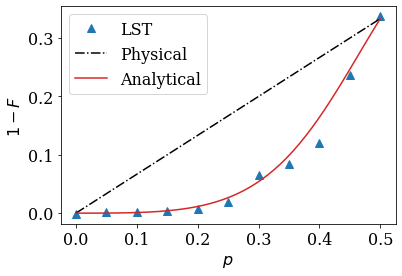

In [11]:
plt.plot(pvalues, 1 - fid_list, "^", markersize=8, label="LST")
plt.plot(pvalues, 2 * pvalues / 3, "-.", c="k", label="Physical")
plt.plot(
    np.linspace(0, 0.5, 50), 1 - FL(np.linspace(0, 0.5, 50)), c="C3", label="Analytical"
)

plt.xlabel("$p$")
plt.ylabel("$1 - F$")
plt.legend();